In [189]:
import pylhe
import itertools
import math as mt
import mplhep as hep
hep.style.use("CMS")
import matplotlib.pyplot as plt
import numpy as np

# Read LHE file

In [190]:
lhe_file = "ttbar/Events/run_06/events.lhe"
events = pylhe.read_lhe_with_attributes(lhe_file)
nevents = pylhe.read_num_events(lhe_file)
print(f"Number of events: {nevents}")

Number of events: 10000


In [191]:
event = next(events)

In [192]:
print(event.graph.source)

digraph {
	0 [label=<<table border="0" cellspacing="0" cellborder="0"><tr><td>g</td></tr></table>> attr_dict="{'id': 21.0, 'status': -1.0, 'mother1': 0.0, 'mother2': 0.0, 'color1': 501.0, 'color2': 502.0, 'px': 0.0, 'py': 0.0, 'pz': 1486.1928165502877, 'e': 1486.1930057922077, 'm': 0.75, 'lifetime': 0.0, 'spin': 9.0, 'event': <pylhe.LHEEvent object at 0x111c80640>}" texlbl="$g$"]
	1 [label=<<table border="0" cellspacing="0" cellborder="0"><tr><td>g</td></tr></table>> attr_dict="{'id': 21.0, 'status': -1.0, 'mother1': 0.0, 'mother2': 0.0, 'color1': 502.0, 'color2': 503.0, 'px': 0.0, 'py': 0.0, 'pz': -85.99508909679207, 'e': 85.99835957019889, 'm': 0.75, 'lifetime': 0.0, 'spin': 9.0, 'event': <pylhe.LHEEvent object at 0x111c80640>}" texlbl="$g$"]
	2 [label=<<table border="0" cellspacing="0" cellborder="0"><tr><td>t</td></tr></table>> attr_dict="{'id': 6.0, 'status': 1.0, 'mother1': 1.0, 'mother2': 2.0, 'color1': 501.0, 'color2': 0.0, 'px': 40.65393997271422, 'py': 1.7558122845422839, 'pz

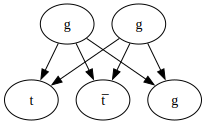

In [193]:
# The graph is nicely displayed as SVG in Jupyter notebooks
event

In [194]:
event.graph.render(filename="test", format="png", cleanup=True)
event.graph.render(filename="test", format="pdf", cleanup=True)

'test.pdf'

# Plot ttbar system quantities 

In [184]:
# Let's build some functions to handle 4 momenta
# Expected format of the input four vec is 
# [px, py, pz, E]

def compute_mass(four_vec: list)-> float:
    return mt.sqrt(four_vec[-1]**2 - (sum(i**2 for i in four_vec[:-1])))

def compute_pt(four_vec: list)-> float:
    return mt.sqrt(four_vec[0]**2 + four_vec[1]**2)

def compute_eta(four_vec: list)-> float:
    return 0.5*mt.log((four_vec[-1] + four_vec[-2])/(four_vec[-1] - four_vec[-2]))

In [185]:
# the average of the event weights is the cross section
xsec = sum(event.eventinfo.weight for event in events) / nevents

In [186]:
xsec

791.59309905

In [187]:
events = pylhe.read_lhe_with_attributes(lhe_file)

tt_mass = []
tt_pt = []
tt_eta = []

t_mass = []
t_pt = []
t_eta = []

cross_section_weight_t = []
cross_section_weight_tt = []

for event in events:
    # select only final state particles
    part = [i for i in event.particles if i.status == 1.0]

    # select only top quarks or antitop quarks from this list
    part = [i for i in part if abs(i.id) == 6]

    # sanity check, we expect part to be a list of two elements
    assert len(part)==2, f"Length of selected particle is not 2: {len(part)}"

    # load the event weight 
    cross_section_weight_tt.append(event.eventinfo.weight)
    
    # build ttbar 4 momenta
    tt_fourm = [0, 0, 0, 0]
    
    # fill single top lists
    for p__ in part:
        four_mom = [p__.px, p__.py, p__.pz, p__.e]
        t_mass.append(compute_mass(four_mom))
        t_pt.append(compute_pt(four_mom))
        t_eta.append(compute_eta(four_mom))
        cross_section_weight_t.append(event.eventinfo.weight)

        for idx in range(4):
            tt_fourm[idx] += four_mom[idx]

    # fill tt system quantities

    tt_mass.append(compute_mass(tt_fourm))
    tt_pt.append(compute_pt(tt_fourm))
    tt_eta.append(compute_eta(tt_fourm))


# In order to obtain the correct normalization for the histograms we need to divide by 
# the number of generated events. Note that this only works without selections

cross_section_weight_t = [i / nevents for i in cross_section_weight_t]
cross_section_weight_tt = [i / nevents for i in cross_section_weight_tt]

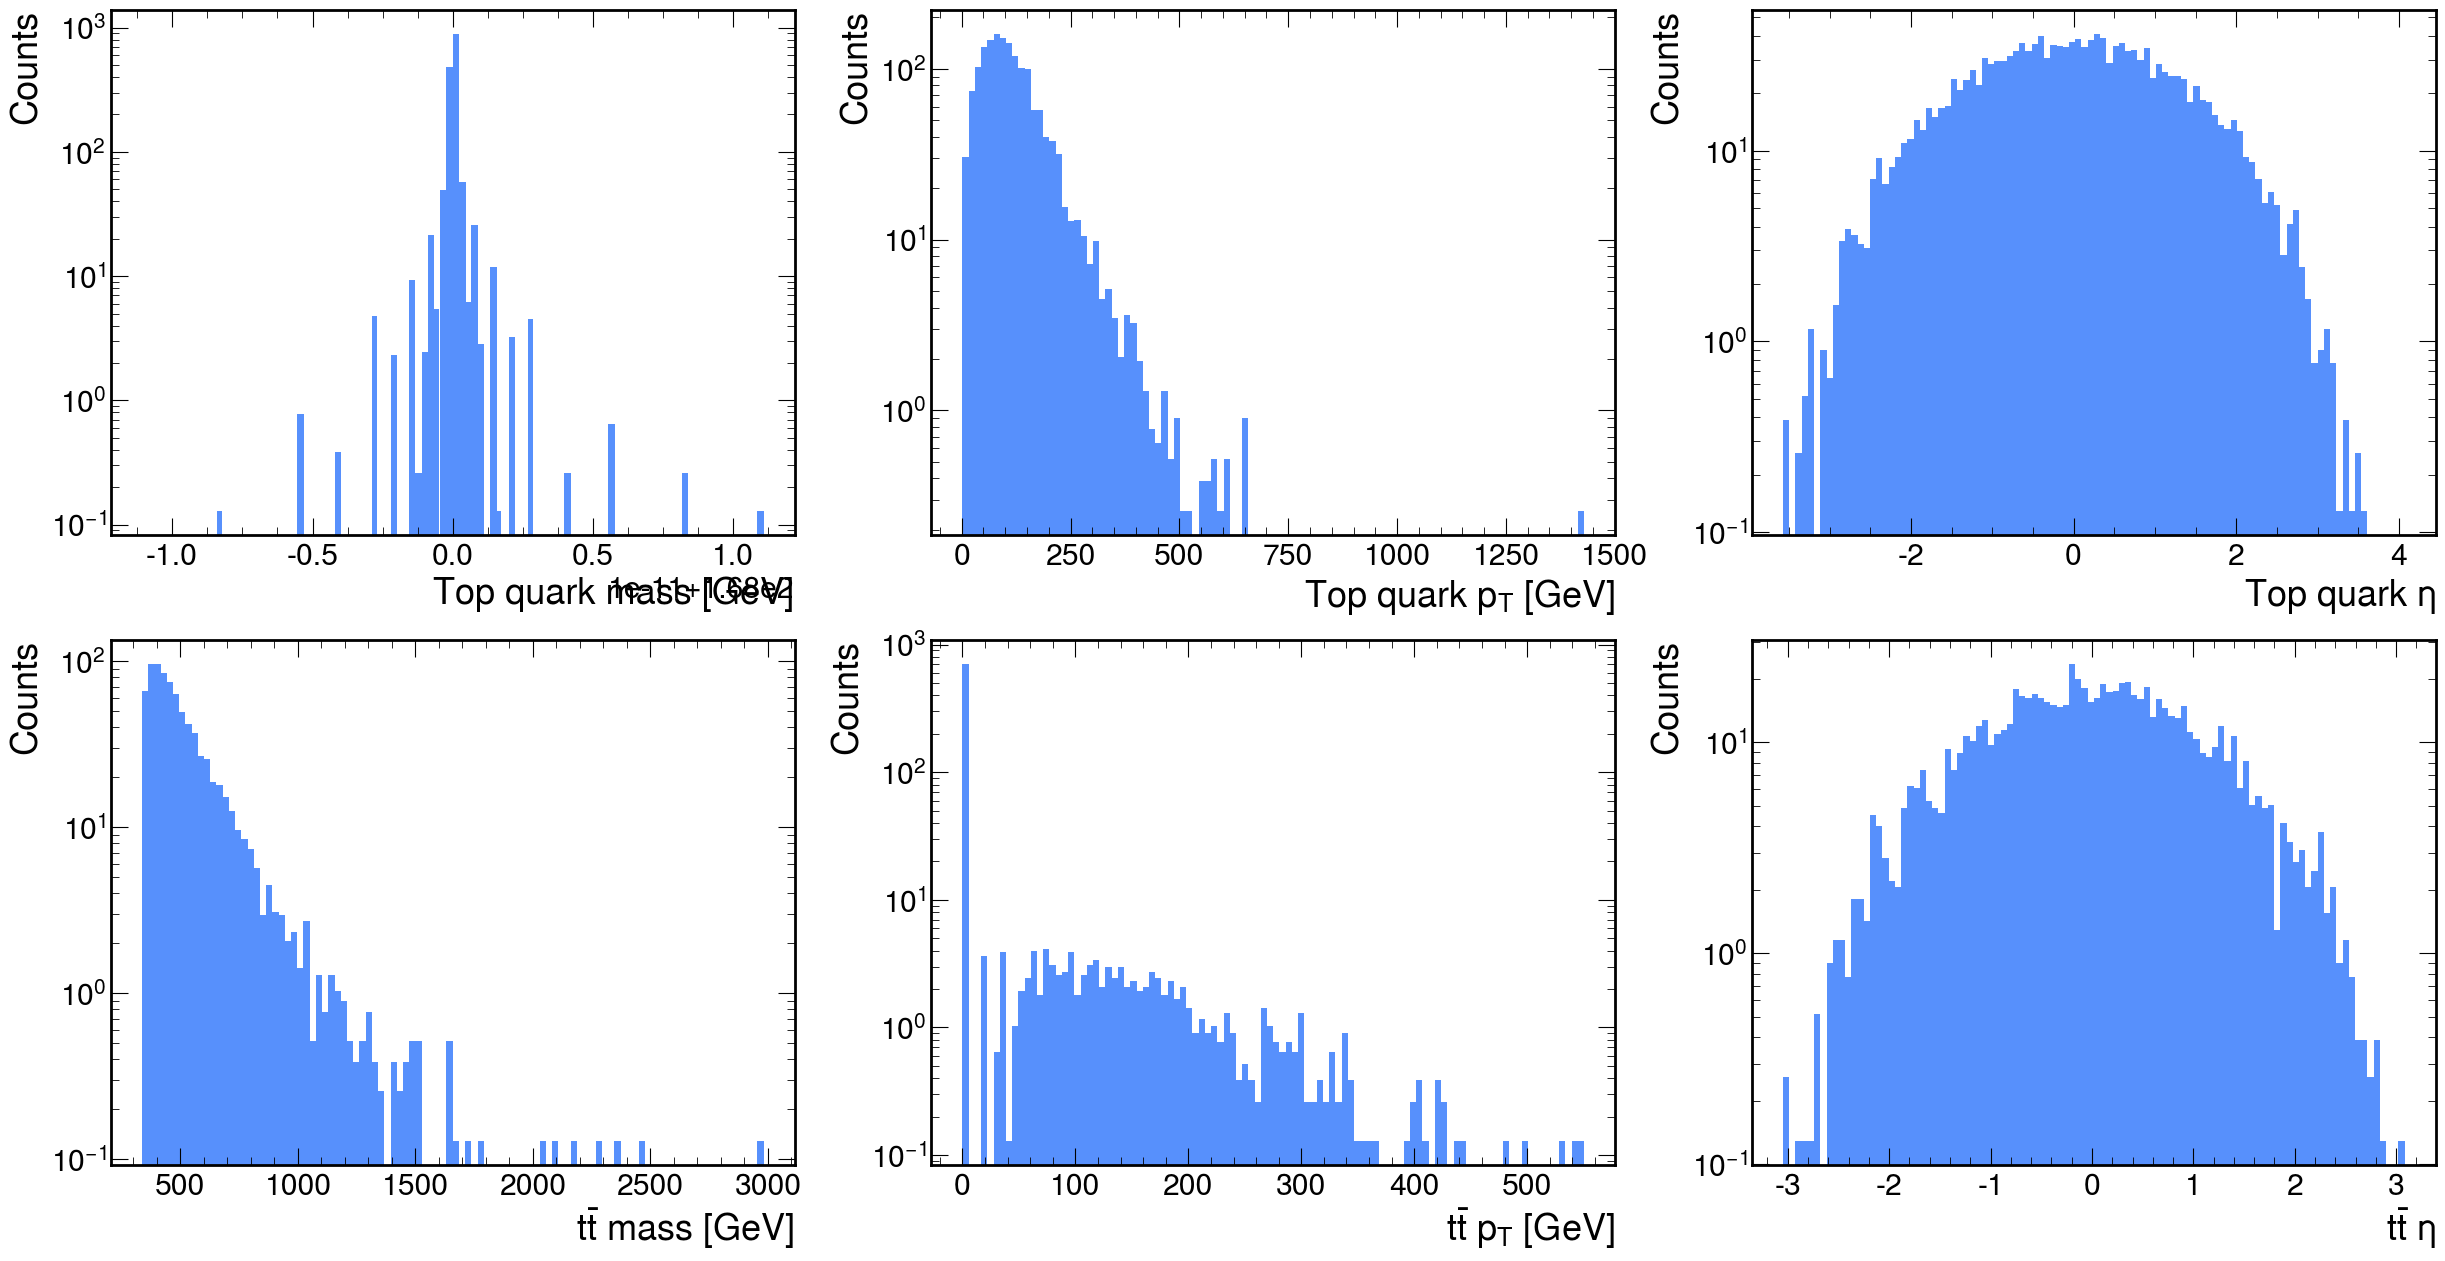

In [188]:
fig, ax = plt.subplots(2,3, figsize=(30, 15))

plot_row = [t_mass, t_pt, t_eta, tt_mass, tt_pt, tt_eta]
labels = [
    r'Top quark mass [GeV]',
    r'Top quark $p_{T}$ [GeV]',
    r'Top quark $\eta$',
    r'$t\bar{t}$ mass [GeV]',
    r'$t\bar{t}$ $p_{T}$ [GeV]',
    r'$t\bar{t}$ $\eta$',
]
for idx in range(len(plot_row)):

    row = 0
    minus = 0
    w = cross_section_weight_t
    if idx > 2: 
        row = 1
        minus = 3
        w = cross_section_weight_tt


    ax[row, idx-minus].hist(plot_row[idx], weights=w, bins=100)
    ax[row, idx-minus].set_xlabel(labels[idx])
    ax[row, idx-minus].set_ylabel('Counts')
    ax[row, idx-minus].set_yscale("log")
    
plt.show()
fig.savefig("top_tt_differential.png")

# How does the ttbar invariant mass distribution change with a change in top quark mass?

In [195]:
files__ = [f'ttbar/Events/run_0{i}/events.lhe' for i in range(1,7)]
top_mass = [166, 168, 170, 172, 174, 176]

In [196]:
tt_mass = dict.fromkeys(top_mass)

for lhe_file, tm in zip(files__, top_mass):

    events = pylhe.read_lhe_with_attributes(lhe_file)
    nevents = pylhe.read_num_events(lhe_file)

    tt_mass[tm] = {"values": [], "weight": []}
    
    for event in events:
        # select only final state particles
        part = [i for i in event.particles if i.status == 1.0]
    
        # select only top quarks or antitop quarks from this list
        part = [i for i in part if abs(i.id) == 6]
    
        # sanity check, we expect part to be a list of two elements
        assert len(part)==2, f"Length of selected particle is not 2: {len(part)}"
    
        # load the event weight 
        tt_mass[tm]["weight"].append(event.eventinfo.weight)
        
        # build ttbar 4 momenta
        tt_fourm = [0, 0, 0, 0]
        
        # fill single top lists
        for p__ in part:
            four_mom = [p__.px, p__.py, p__.pz, p__.e]
            t_mass.append(compute_mass(four_mom))
            t_pt.append(compute_pt(four_mom))
            t_eta.append(compute_eta(four_mom))
            cross_section_weight_t.append(event.eventinfo.weight)
    
            for idx in range(4):
                tt_fourm[idx] += four_mom[idx]
    
        # fill tt system quantities
        tt_mass[tm]["values"].append(compute_mass(tt_fourm))
    
    
    # In order to obtain the correct normalization for the histograms we need to divide by 
    # the number of generated events. Note that this only works without selections
    
    tt_mass[tm]["weight"] = [i / nevents for i in tt_mass[tm]["weight"]]

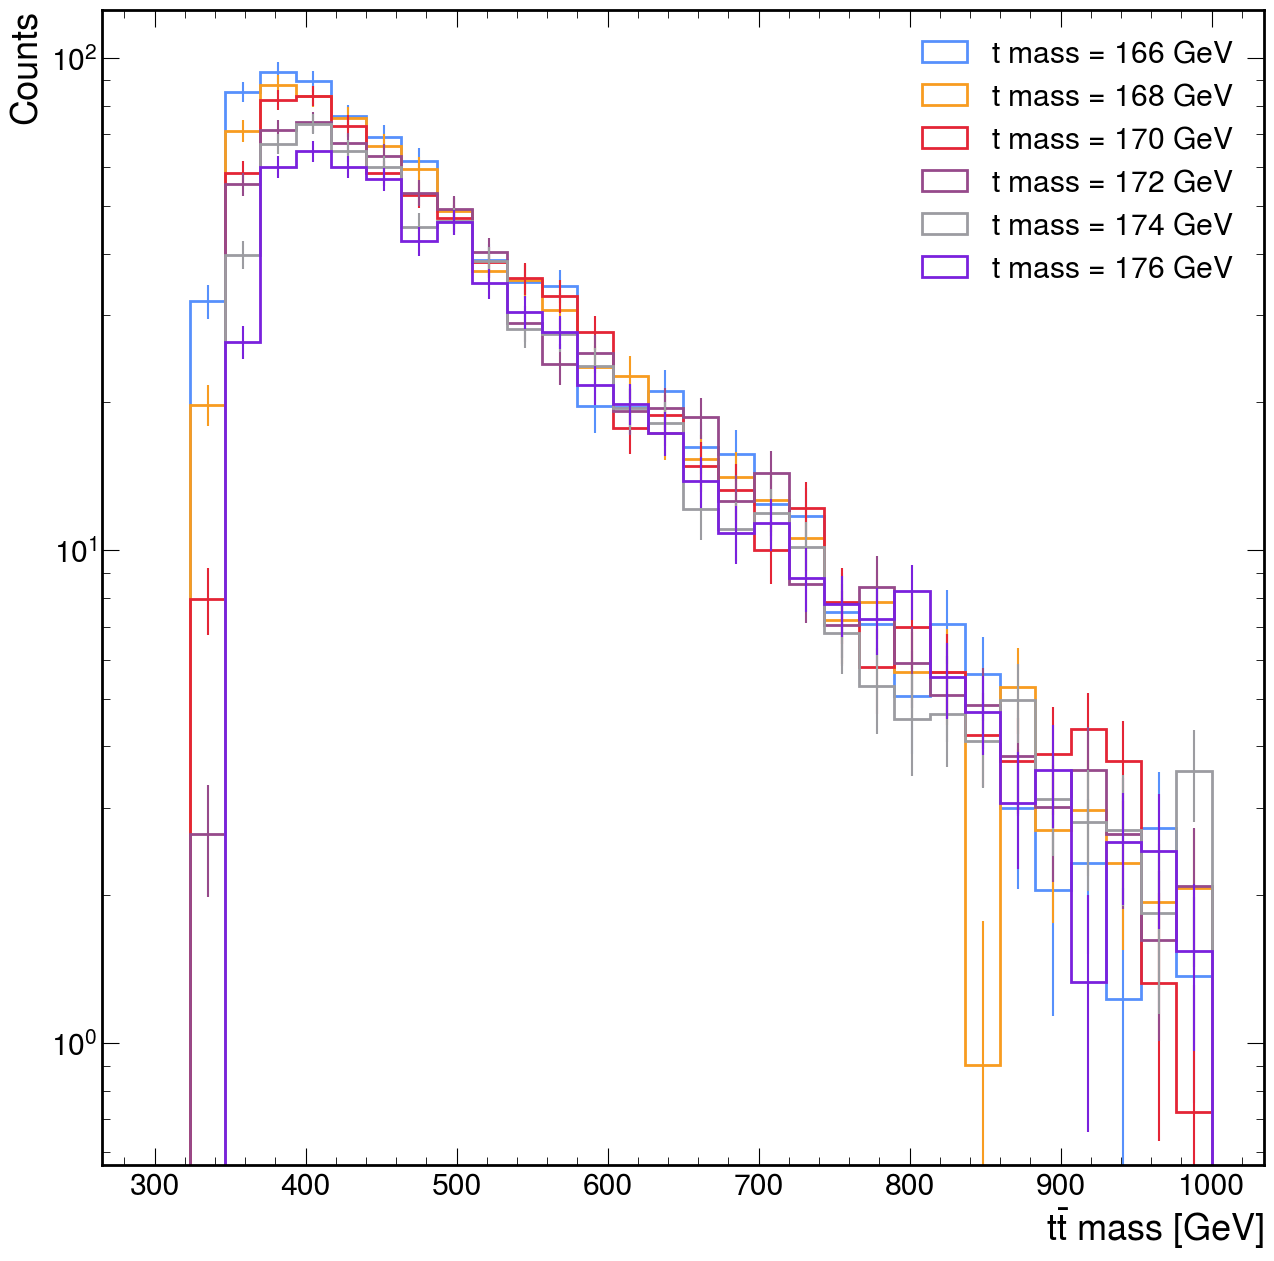

In [197]:
fig, ax = plt.subplots(figsize=(15, 15))

# to plot histograms
nbins = 30
r__ = [300, 1000]


for mass in tt_mass.keys():
    label = rf"$t$ mass = {mass} GeV"
    
    n, bins, p = ax.hist(tt_mass[mass]["values"], weights=tt_mass[mass]["weight"], bins=nbins, label=label, histtype=u'step', linewidth=2, range=r__)

    # to compute statistical error we use sumw2 for each bin. We make another histogram
    sumw2, _  = np.histogram(tt_mass[mass]["values"], nbins,  weights=[i**2 for i in tt_mass[mass]["weight"]], range=r__)
    err = np.sqrt(sumw2)
    mid = 0.5*(bins[1:] + bins[:-1])
    
    ax.errorbar(mid, n, yerr=err, fmt='none', ecolor=p[0].get_edgecolor())

ax.legend(loc="best")
ax.set_xlabel(r"$t\bar{t}$ mass [GeV]")
ax.set_ylabel('Counts')
ax.set_yscale("log")
    
plt.show()
fig.savefig("tt_mass_differential.png")

# Reweighting and EFT

In [219]:
lhe_file = "Zjj_EFT/Events/run_01/unweighted_events.lhe"
events = pylhe.read_lhe_with_attributes(lhe_file)
nevents = pylhe.read_num_events(lhe_file)
print(f"Number of events: {nevents}")

Number of events: 11926


In [220]:
event = next(events)

In [226]:
mjj = []

sm_w = []
chwb1_w = []
chwbm1_w = []
chdd1_w = []
chddm1_w = []
ceu1_w = []
ceum1_w = []

events = pylhe.read_lhe_with_attributes(lhe_file)
nevents = pylhe.read_num_events(lhe_file)

for event in events:
    # select only final state particles
    part = [i for i in event.particles if i.status == 1.0]

    # select only top quarks or antitop quarks from this list
    lep = [i for i in part if abs(i.id) in [11, 12, 13, 14, 15, 16, 17, 18]]
    jets = [i for i in part if abs(i.id) in [1,2,3,4,5,6,7,8]]

    # sanity check, we expect part to be a list of two elements
    assert len(jets)==2, f"Length of selected jets is not 2: {len(jets)}"
    assert len(lep)==2, f"Length of selected leptons is not 2: {len(lep)}"

    # load the event weight 
    sm_w.append(event.weights['sm'])
    chwb1_w.append(event.weights['chwb_1'])
    chwbm1_w.append(event.weights['chwb_m1'])
    chdd1_w.append(event.weights['chdd_1'])
    chddm1_w.append(event.weights['chdd_m1'])
    ceu1_w.append(event.weights['ceu_1'])
    ceum1_w.append(event.weights['ceu_m1'])
    
    # build ttbar 4 momenta
    jj_fourm = [0, 0, 0, 0]
    
    # fill single top lists
    for p__ in jets:
        four_mom = [p__.px, p__.py, p__.pz, p__.e]
        for idx in range(4):
            jj_fourm[idx] += four_mom[idx]

    # fill tt system quantities
    mjj.append(compute_mass(jj_fourm))


# In order to obtain the correct normalization for the histograms we need to divide by 
# the number of generated events. Note that this only works without selections

sm_w = [i / nevents for i in sm_w]
chwb1_w = [i / nevents for i in chwb1_w]
chwbm1_w = [i / nevents for i in chwbm1_w]
chdd1_w = [i / nevents for i in chdd1_w]
chddm1_w = [i / nevents for i in chddm1_w]
ceu1_w = [i / nevents for i in ceu1_w]
ceum1_w = [i / nevents for i in ceum1_w]

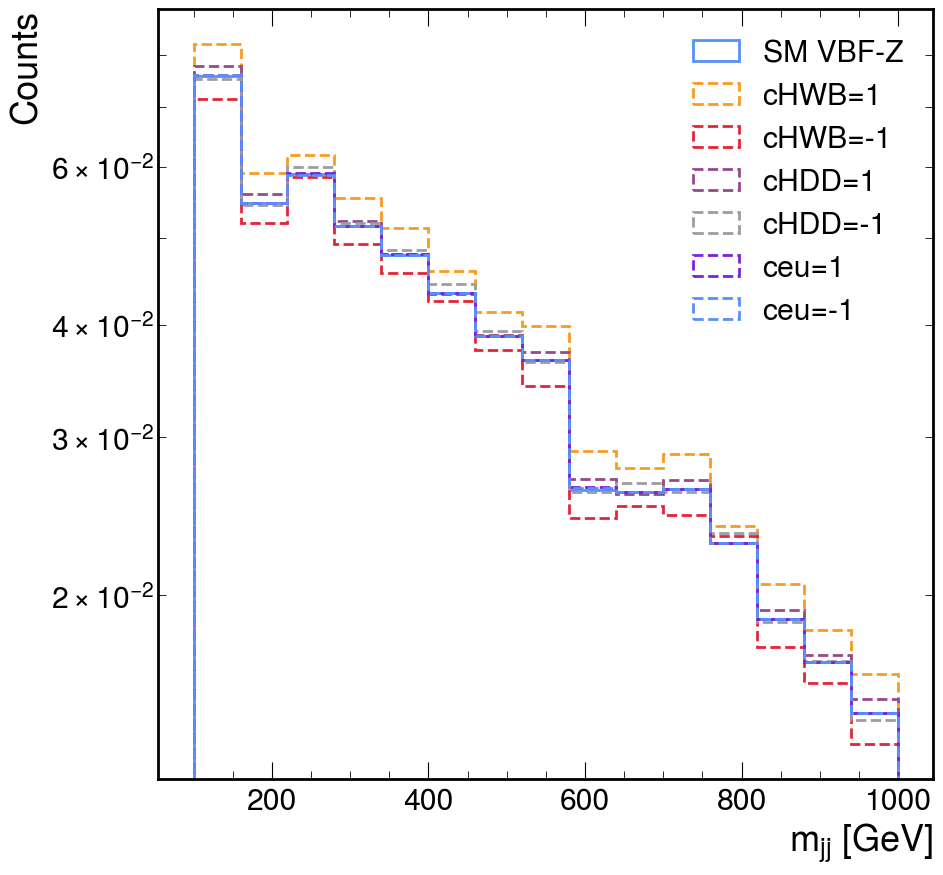

In [254]:
fig, ax = plt.subplots(figsize=(10, 10))

# to plot histograms
nbins = 15
r__ = [100, 1000]

n, bins, p = ax.hist(mjj, weights=sm_w, bins=nbins, label="SM VBF-Z", histtype=u'step', linewidth=2, range=r__)
n_chwb1, bins, p = ax.hist(mjj, weights=chwb1_w, bins=nbins, label="cHWB=1", histtype=u'step', linewidth=2, linestyle='--', range=r__)
n_chwbm1, bins, p = ax.hist(mjj, weights=chwbm1_w, bins=nbins, label="cHWB=-1", histtype=u'step', linewidth=2, linestyle='--', range=r__)
n_chdd1, bins, p = ax.hist(mjj, weights=chdd1_w, bins=nbins, label="cHDD=1", histtype=u'step', linewidth=2, linestyle='--', range=r__)
n_chddm1, bins, p = ax.hist(mjj, weights=chddm1_w, bins=nbins, label="cHDD=-1", histtype=u'step', linewidth=2, linestyle='--', range=r__)
n_ceu1, bins, p = ax.hist(mjj, weights=ceu1_w, bins=nbins, label="ceu=1", histtype=u'step', linewidth=2, linestyle='--', range=r__)
n_ceum1, bins, p = ax.hist(mjj, weights=ceum1_w, bins=nbins, label="ceu=-1", histtype=u'step', linewidth=2, linestyle='--', range=r__)


ax.legend(loc="best")
ax.set_xlabel(r"$m_{jj}$ [GeV]")
ax.set_ylabel('Counts')
ax.set_yscale("log")
    
plt.show()
fig.tight_layout()
fig.savefig("Zjj_EFT_summary.png")

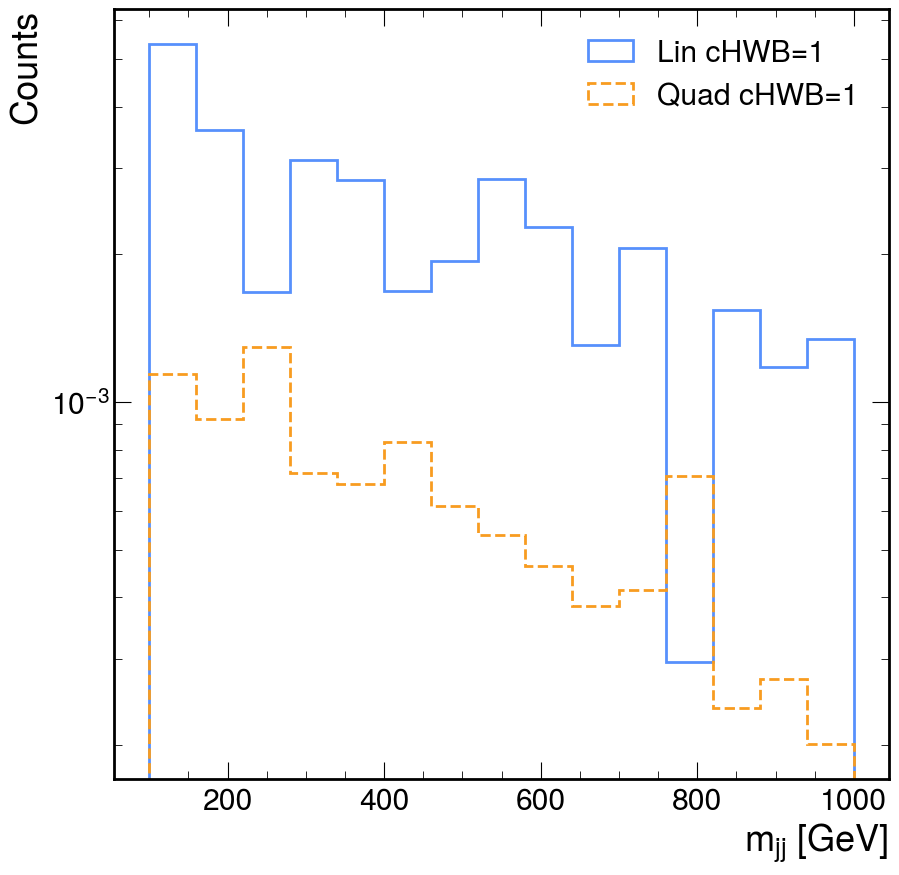

In [237]:
lin_chwb = [0.5*(i-j) for i,j in zip(chwb1_w, chwbm1_w)]
quad_chwb = [0.5*(i+j-2*k) for i,j,k in zip(chwb1_w, chwbm1_w,sm_w)]

# to plot histograms

fig, ax = plt.subplots(figsize=(10, 10))
nbins = 15
r__ = [100, 1000]

n_lin, bins, p = ax.hist(mjj, weights=lin_chwb, bins=nbins, label="Lin cHWB=1", histtype=u'step', linewidth=2, range=r__)
n_quad, bins, p = ax.hist(mjj, weights=quad_chwb, bins=nbins, label="Quad cHWB=1", histtype=u'step', linewidth=2, linestyle='--', range=r__)

ax.legend(loc="best")
ax.set_xlabel(r"$m_{jj}$ [GeV]")
ax.set_ylabel('Counts')
ax.set_yscale("log")
    
plt.show()
fig.tight_layout()
fig.savefig("Zjj_EFT_lin_quad_summary.png")

In [288]:
# let's suppose that data = sm prediction, how much does the EFT 
# prediction change with a change in the wilson coefficient?

lin_chwb = [0.5*(i-j) for i,j in zip(chwb1_w, chwbm1_w)]
quad_chwb = [0.5*(i+j-2*k) for i,j,k in zip(chwb1_w, chwbm1_w,sm_w)]

sm, _  = np.histogram(mjj, nbins,  weights=sm_w, range=r__)
lin, _  = np.histogram(mjj, nbins,  weights=lin_chwb, range=r__)
quad, _  = np.histogram(mjj, nbins,  weights=quad_chwb, range=r__)


c = np.linspace(-5, 2,100)

chi = [sum(np.pow(sm - (sm+(ci)*lin+(ci**2)*quad), 2)) for ci in c]

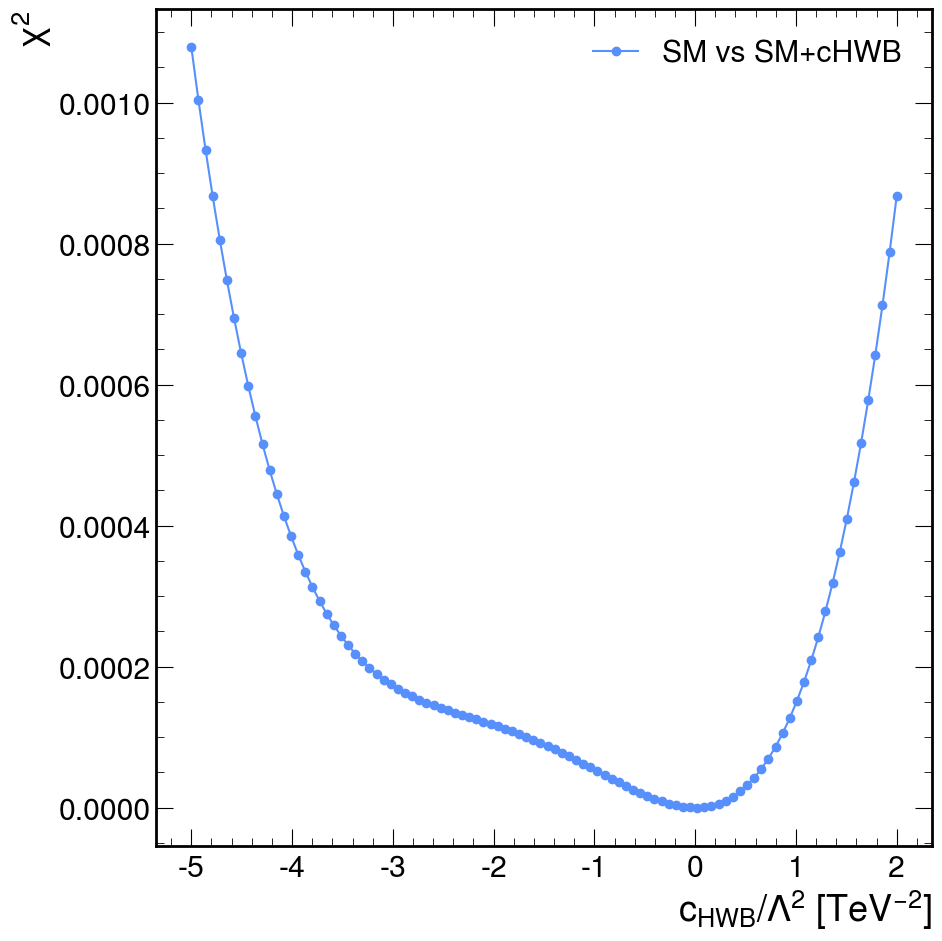

In [298]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(c, chi, label=r'SM vs SM+cHWB', marker='o')

ax.legend(loc="best")
ax.set_xlabel(r"$c_{HWB}/\Lambda^2$ [$TeV^{-2}$]")
ax.set_ylabel(r'$\chi^2$')    

fig.tight_layout()
fig.savefig("cHWB_sensitivity.png")

In [262]:
sm + lin + quad

array([0.08220454, 0.05912528, 0.06181487, 0.05543772, 0.05132547,
       0.04590599, 0.04137797, 0.0399089 , 0.02895111, 0.02774426,
       0.02870575, 0.0238894 , 0.02058253, 0.01830859, 0.01634185])

In [280]:
sum(np.pow((sm + 10*lin + 100*quad)-sm, 2))

np.float64(0.12986837628552025)

In [281]:
chi

[np.float64(0.03606333549978413),
 np.float64(0.03270463114022908),
 np.float64(0.029587099396511926),
 np.float64(0.02669893815579171),
 np.float64(0.024028639520791956),
 np.float64(0.02156498980980074),
 np.float64(0.01929706955667067),
 np.float64(0.01721425351081893),
 np.float64(0.015306210637227131),
 np.float64(0.013562904116441522),
 np.float64(0.01197459134457281),
 np.float64(0.010531823933296283),
 np.float64(0.009225447709851725),
 np.float64(0.008046602717043468),
 np.float64(0.006986723213240364),
 np.float64(0.00603753767237582),
 np.float64(0.005191068783947745),
 np.float64(0.004439633453018589),
 np.float64(0.003775842800215342),
 np.float64(0.0031926021617295188),
 np.float64(0.0026831110893171632),
 np.float64(0.002240863350298856),
 np.float64(0.0018596469275597002),
 np.float64(0.0015335440195493387),
 np.float64(0.0012569310402819381),
 np.float64(0.001024478619336203),
 np.float64(0.0008311516018553667),
 np.float64(0.0006722090485471913),
 np.float64(0.0005432